# Simulating InSAR Noise Data

## 0. Importing Data and Setting Up Clean Background

We need to start by having a "clean" background to view our noise over. This can just be a 0 of the same size as our noise matrices. When training, this needs to be an actual image. Preferably of as close to 'clean' InSAR data as possible.

We are setting our default size to be 1500x1500 as that's what the example paper had.

In [27]:
import numpy as np
import matplotlib.pyplot as plt

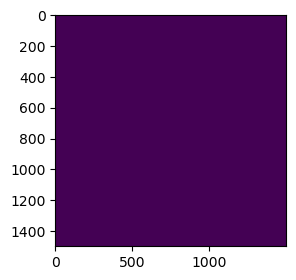

In [28]:
# Define our clean image as an empty array
size = (1500, 1500)
clean = np.zeros(size)

plt.figure(figsize=(3,3))
plt.imshow(clean)

## 1. Simulating Random Noise as a Gaussian Distribution 

The easiest type of noise we can add is the random noise, as we are simulating this as a Gaussian (normal) distribution with a $\mu = 0$ and $\sigma = 0.56$. This is a simple function built into numpy.

In [29]:
def generate_random_noise(size, std=0.56):
    # Return a matrix with a normal distribution with mean at 0 and passed in size/std
    return np.random.normal(loc=0.0, scale=std, size=size)

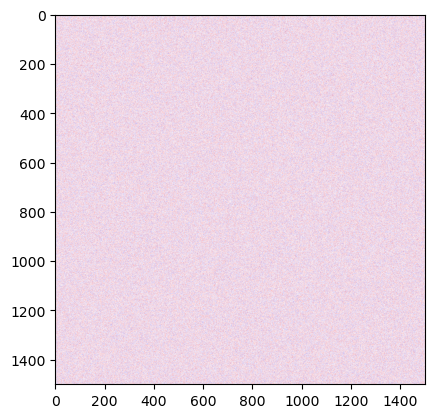

In [30]:
test_gaus = generate_random_noise(size)
plt.imshow(test_gaus, cmap='bwr')

## 2. Simulating Tropospheric Noise

The second type of noise we want to add is tropospheric noise. 

This noise is slightly different than our Gaussian noise as it's not "White Noise." That is to say, each pixel is not independent in picking from the distribution. 

Rather, the frequency across the x and y axes determines the noise level at a specific pixel. In our case, the distirbution follows the "Power Law" $P(k) \propto k^{-\beta}$, where $k$ is the spatial frequency, and $\beta$ is a constant controlling how quickly power decays with frequency. From the given paper we will use $\beta = 1.82$.

However, because we are dealing discrete pixels (not a continuous distribution) we need to use np.fft.fftfreq() to generate a discrete frequency array for our pixels. We need to do this for both the x and y axis. After this we can calculate the radial frequency (circular frequency from the center) by calculating the magnitude as $k = \sqrt{k_{x}^{2} + k_{y}^{2}}$

In [31]:
def generate_tropospheric_noise(size, beta=1.82, scale=1.0):
    # Create a frequency domain based on a standard normal distribution
    noise = np.fft.fft2(np.random.randn(*size)) 

    # Create our discrte frequency distributions over x and y axes
    ky = np.fft.fftfreq(size[0])
    kx = np.fft.fftfreq(size[1])

    # Mesh them together get the specific axes
    kx, ky = np.meshgrid(kx, ky)

    # Compute the radial spatial frequency (frequency from the center)
    k = np.sqrt(kx**2 + ky**2)
    k[0, 0] = 1e-7

    # Calculate the power law
    power = k ** (-beta)

    # Use inverse fourier transform to calculate it back in spatial domain
    frac_noise = np.fft.ifft2(noise * power).real

    # Normalize it
    frac_noise = (frac_noise - frac_noise.mean()) / frac_noise.std()
    return frac_noise * scale

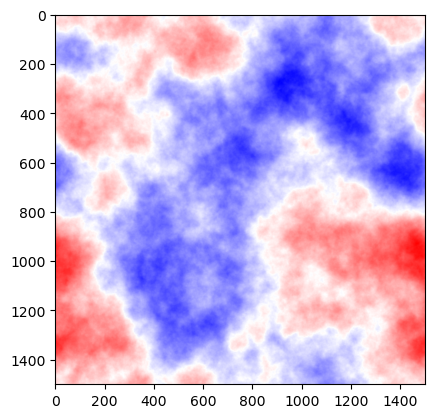

In [32]:
test_trop = generate_tropospheric_noise(size)
plt.imshow(test_trop, cmap='bwr')

# 3. Simulating Residual Topographic Noise

In the powerpoint we are given that the residuals from the topographic phase in given by:

$\phi_{topo} = \frac{4\pi B_{\perp}}{\lambda R sin \theta} \Delta h$

The other parameters are dependent on the type of satellite being used while $\Delta h$ is the DEM error at each pixel which is what we need to simulated. For now, we can simulate it using a standard guassian distribution. I am performing further research to find a better formula for simulating this.

In [33]:
def generate_topographic_dem_noise(size, dem_error_std_dev=5, wavelength=0.056, perpendicular_baseline=100.0, slant_range=800000.0, incidence_angle_deg=35.0):
    delta_h = np.random.randn(*size) * dem_error_std_dev
    incidence_angle_rad = np.deg2rad(incidence_angle_deg)
    K = (4 * np.pi * perpendicular_baseline) / (wavelength * slant_range * np.sin(incidence_angle_rad))
    phi_topo_res = K * delta_h
    return phi_topo_res

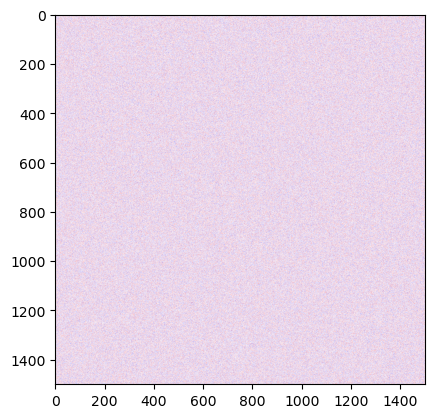

In [34]:
test_dem = generate_topographic_dem_noise(size)
plt.imshow(test_dem, cmap='bwr')

# 4. Simulating Subsidence Background

The final piece we need to be simulating, is the background of the image itself. Using the synthetic subsidence "Zoback model" outlined in the paper we mathematically calculate what we are aiming to recover with our CNN models.

The formulas given were for the radial displacement and the vertical displacement:

$u_{r}(r, 0) = -\frac{1}{\pi c_m (1 - v)} \frac{r}{(r^2 + D^2)^\frac{3}{2}} \Delta P_p V$

All these parameters are properly defined in the given powerpoint and outlined in the referenced paper. We need to simply use the vertical formula as we are only simulating 1 satellite for now.

However, this formula will give us values between [-max_disp_cm, 0] we need to shift it to [-max_disp_cm, max_disp_cm] by rescaling.

In [35]:
def generate_vertical_displacement(size, D=50, delta_P=1.0, nu=0.25, cm=1.0, V=1.0, max_disp_cm=5.0):
    y, x = np.indices(size)
    cx, cy = size[1] // 2, size[0] // 2
    r = np.sqrt((x - cx)**2 + (y - cy)**2)

    factor = -1 / (np.pi * cm * (1 - nu)) * delta_P * V
    
    uz_raw = factor * (D / ((r**2 + D**2)**1.5))

    min_val = np.min(uz_raw)

    A = -2 * max_disp_cm / min_val
    B = max_disp_cm

    uz = A * uz_raw + B

    return uz

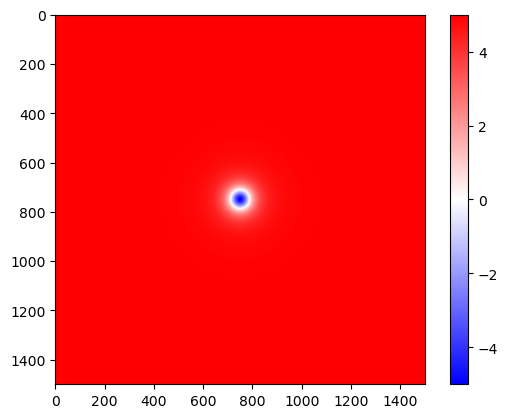

In [36]:
test_sub = generate_vertical_displacement(size)
plt.imshow(test_sub, cmap='bwr')
plt.colorbar()

For now, this displacement remains static. However we can add our noise on top of it to generate a combined image.

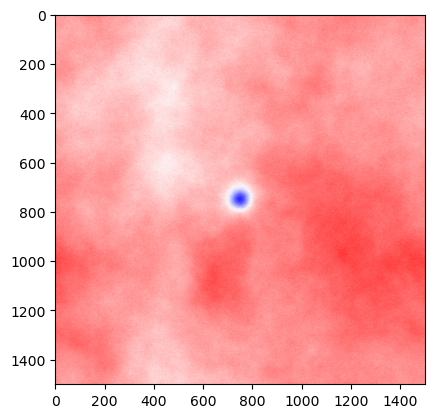

In [37]:
test_img = generate_vertical_displacement(size) + generate_tropospheric_noise(size) + generate_random_noise(size)
plt.imshow(test_img, cmap='bwr')

# 5. Generating Synthetic Time-Series Data

To properly simulate really satellite data, we need to change the displacement values over some interval of days. In the paper this was tested against both a linear and logarithmic change in discplacement over intervals of 49 days each. Because the tropospheric and random noise are implemented randomly we can just call those functions. However, we need to iterate over our time series for both log and linear discplacements to create our synthetic time-series data.

In [38]:
def get_times(total_days=1460, interval_days=49):
    # Return an array of days of step size interval_days
    return np.arange(0, total_days + 1, interval_days)

times = get_times()
times

array([   0,   49,   98,  147,  196,  245,  294,  343,  392,  441,  490,
        539,  588,  637,  686,  735,  784,  833,  882,  931,  980, 1029,
       1078, 1127, 1176, 1225, 1274, 1323, 1372, 1421])

To create an array representing the linear change in discplacement, we can divide our times array by 365 (i.e. convert from days to years from start) and multiply by some the linear deformation rate in cm/year $A$. The paper said this was 0.75 cm / year.

$A \frac{times[]}{365}$

In [39]:
def linear_displacement(times, A=0.75):
    return A * (times / 365)

lin = linear_displacement(times)
lin

array([0.        , 0.10068493, 0.20136986, 0.30205479, 0.40273973,
       0.50342466, 0.60410959, 0.70479452, 0.80547945, 0.90616438,
       1.00684932, 1.10753425, 1.20821918, 1.30890411, 1.40958904,
       1.51027397, 1.6109589 , 1.71164384, 1.81232877, 1.9130137 ,
       2.01369863, 2.11438356, 2.21506849, 2.31575342, 2.41643836,
       2.51712329, 2.61780822, 2.71849315, 2.81917808, 2.91986301])

To create an array representing the logairhtmic change in displacement, we can multiply the logarithmic decay displacement rate $B$ by the natural log of the year. This was chosen as 1.86 cm / year in the paper.

$B ln(t + 1)$

In [40]:
def log_displacement(times, B=1.86):
    return B * np.log1p(times / 365)

log = log_displacement(times)
log

array([0.        , 0.23430163, 0.44236324, 0.62947472, 0.79947181,
       0.95522458, 1.0989367 , 1.23233694, 1.35680657, 1.47346668,
       1.58323965, 1.68689353, 1.78507464, 1.87833203, 1.96713603,
       2.05189268, 2.13295486, 2.21063125, 2.28519338, 2.35688137,
       2.42590861, 2.49246554, 2.5567229 , 2.61883429, 2.67893844,
       2.73716101, 2.79361626, 2.84840832, 2.90163239, 2.95337572])

If different locations are found to have different displacement rates, or for the purposes of training off a variety of data, we can always adjust the constants or create new formulas for getting these displacement values.

The next step is to actually generate these time series images. This is quite trivial we just need to iterate over our displacement and pass this into our vertical displacement function. 

In [41]:
def generate_linear_timeseries(size, interval_days):
    times = get_times(interval_days=interval_days)
    displacements = linear_displacement(times)
    time_series = []
    for d in displacements:
        uz = generate_vertical_displacement(size, max_disp_cm=d)
        noise = generate_tropospheric_noise(size) + generate_random_noise(size)
        combined = uz + noise
        time_series.append(combined)
        
    return time_series, times

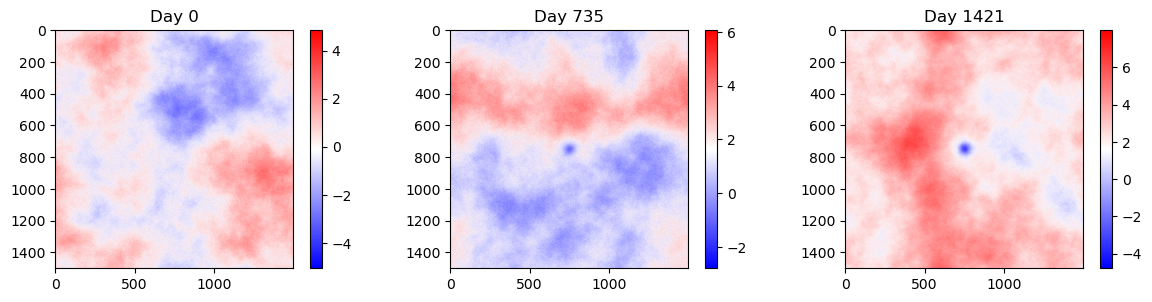

In [42]:
series, times = generate_linear_timeseries(size, interval_days=49)

# Plot a few time steps
plt.figure(figsize=(12, 3))
for i, t in enumerate([0, len(times)//2, -1]):
    plt.subplot(1, 3, i + 1)
    plt.title(f"Day {int(times[t])}")
    plt.imshow(series[t], cmap='bwr')
    plt.colorbar()
plt.tight_layout()
plt.show()

We can do the same with log timeseries.

In [43]:
def generate_log_timeseries(size, interval_days):
    times = get_times(interval_days=interval_days)
    displacements = log_displacement(times)
    time_series = []
    for d in displacements:
        uz = generate_vertical_displacement(size, max_disp_cm=d)
        noise = generate_tropospheric_noise(size) + generate_random_noise(size)
        combined = uz + noise
        time_series.append(combined)
        
    return time_series, times

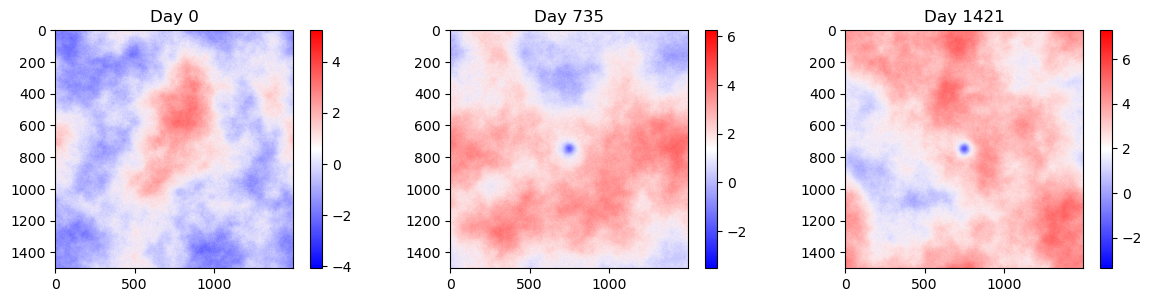

In [44]:
series, times = generate_log_timeseries(size, interval_days=49)

# Plot a few time steps
plt.figure(figsize=(12, 3))
for i, t in enumerate([0, len(times)//2, -1]):
    plt.subplot(1, 3, i + 1)
    plt.title(f"Day {int(times[t])}")
    plt.imshow(series[t], cmap='bwr')
    plt.colorbar()
plt.tight_layout()
plt.show()

We can make this simpler so when we build our data generation class we can input "linear" or "log" to generate the type of data we need.

In [45]:
def generate_timeseries(size, mode="linear", interval_days=49):
    if(mode == "linear"):
        time_series, times = generate_linear_timeseries(size, interval_days)
    elif(mode == "log"):
        time_series, times = generate_log_timeseries(size, interval_days)
    else:
        print("Incorrect Mode Type")
    return time_series, times

## 6. Designing a Class for Generating Pairs of Noisy Data

We can start adding all the functions we created into a class for easy generation of pairs of data. This will allow us to easily wrap it in a "Dataset" class from Pytorch or tensorflow to have easy data loading.

In [46]:
class InSARDataGenerator:
    def __init__(self, size=(1500,1500), model='linear', interval_days=49, 
                 duration_days=1460, std=0.56, beta=1.82, rate=0.75):
        # Initialize class with given params
        self.size = size
        self.model = model
        self.interval_days = interval_days
        self.duration_days = duration_days
        self.std = std
        self.beta = beta
        self.rate = rate
        self.times = np.arange(0, self.duration_days + 1, self.interval_days)

    def __len__(self):
        # Get the length of the dataset as the length of time (since its time-series)
        return len(self.times)

    def get_displacement(self, day):
        # Calculate the max_displacement for a given day using the dataset type
        if self.model == "linear":
            max_disp = self.rate * (day / 365)
        elif self.model == "log":
            max_disp = self.rate * np.log1p(day / 365)
        else:
            raise ValueError("Unknown displacement type")
        return self._generate_vertical_displacement(max_disp)

    def _generate_vertical_displacement(self, max_disp_cm):
        # Get the indices per axis
        y, x = np.indices(self.size)
        
        # Get the center points
        cx, cy = self.size[1] // 2, self.size[0] // 2

        # Calculate the radial distance between each point
        r = np.sqrt((x - cx)**2 + (y - cy)**2)

        # Apply the formula with our constants
        D, nu, cm, delta_P, V = 50, 0.25, 1.0, 1.0, 1.0
        factor = -1 / (np.pi * cm * (1 - nu)) * delta_P * V
        uz = factor * (D / ((r**2 + D**2)**1.5))

        # Normalize around the max displacement
        uz = uz / np.max(np.abs(uz)) * max_disp_cm
        return uz

    '''
    def _generate_topographic_dem_noise(self, dem_error_std_dev=5, wavelength=0.056, perpendicular_baseline=100.0, slant_range=800000.0, incidence_angle_deg=35.0):
        delta_h = np.random.randn(*self.size) * dem_error_std_dev
        incidence_angle_rad = np.deg2rad(incidence_angle_deg)
        K = (4 * np.pi * perpendicular_baseline) / (wavelength * slant_range * np.sin(incidence_angle_rad))
        phi_topo_res = K * delta_h
        return phi_topo_res
    '''

    def _generate_tropospheric_noise(self):
        # Get discrete frequencies given the size
        noise = np.fft.fft2(np.random.randn(*self.size))
        ky = np.fft.fftfreq(self.size[0])
        kx = np.fft.fftfreq(self.size[1])
        kx, ky = np.meshgrid(kx, ky)

        # Calculate magnitude of k given its components
        k = np.sqrt(kx**2 + ky**2)

        # Apply the formula to get the actual noise image
        k[0, 0] = 1e-6
        power = k ** (-self.beta)
        frac_noise = np.fft.ifft2(noise * power).real
        frac_noise = (frac_noise - frac_noise.mean()) / frac_noise.std()
        return frac_noise

    def _generate_uncorrelated_noise(self):
        # Get a guassian distribution with mean=0 and std=std for our img
        return np.random.normal(0, self.std, size=self.size)

    def __getitem__(self, index):
        # Return a pair of noisy images based on the same displacement (same day)
        day = self.times[index]
        clean = self.get_displacement(day)
        noisy_1 = clean + self._generate_tropospheric_noise() + self._generate_uncorrelated_noise() #+ self._generate_topographic_dem_noise()
        noisy_2 = clean + self._generate_tropospheric_noise() + self._generate_uncorrelated_noise() #+ self._generate_topographic_dem_noise()
        return noisy_1, noisy_2

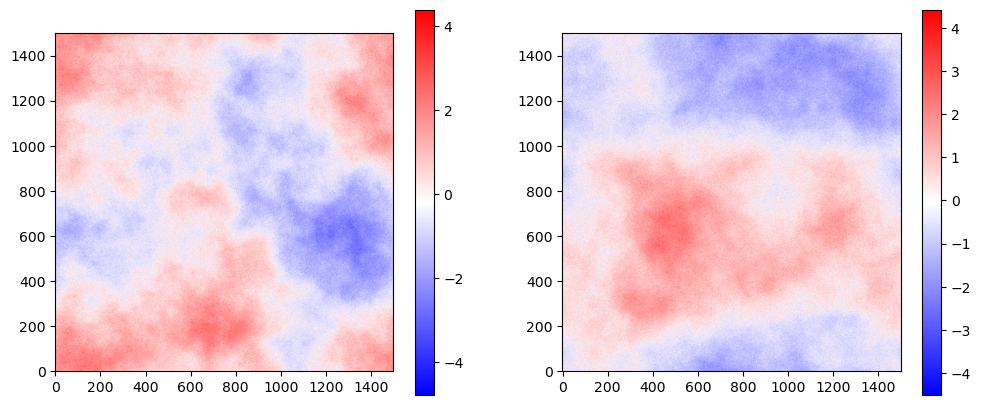

In [47]:
ds = InSARDataGenerator(model='log', interval_days=14.7)

x, y = ds[0]
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

im1 = axes[0].imshow(x, cmap='bwr', origin='lower')
plt.colorbar(im1, ax=axes[0])
im2 = axes[1].imshow(y, cmap='bwr', origin='lower')
plt.colorbar(im2, ax=axes[1])

In [23]:
'''
import os
ds = InSARDataGenerator(model='log', interval_days=14.7)

output_dir = 'insar_images'
os.makedirs(output_dir, exist_ok=True)

for i, (x, y) in enumerate(ds):
    # Define filenames
    filename_x = os.path.join(output_dir, f'img{i+1}_x.npy') # Using .npy for NumPy arrays
    filename_y = os.path.join(output_dir, f'img{i+1}_y.npy')

    # Save the images
    np.save(filename_x, x)
    np.save(filename_y, y)

    print(f"Saved {filename_x} and {filename_y}")

print(f"\nAll image pairs saved to the '{output_dir}' directory.")
'''

Saved insar_images\img1_x.npy and insar_images\img1_y.npy
Saved insar_images\img2_x.npy and insar_images\img2_y.npy
Saved insar_images\img3_x.npy and insar_images\img3_y.npy
Saved insar_images\img4_x.npy and insar_images\img4_y.npy
Saved insar_images\img5_x.npy and insar_images\img5_y.npy
Saved insar_images\img6_x.npy and insar_images\img6_y.npy
Saved insar_images\img7_x.npy and insar_images\img7_y.npy
Saved insar_images\img8_x.npy and insar_images\img8_y.npy
Saved insar_images\img9_x.npy and insar_images\img9_y.npy
Saved insar_images\img10_x.npy and insar_images\img10_y.npy
Saved insar_images\img11_x.npy and insar_images\img11_y.npy
Saved insar_images\img12_x.npy and insar_images\img12_y.npy
Saved insar_images\img13_x.npy and insar_images\img13_y.npy
Saved insar_images\img14_x.npy and insar_images\img14_y.npy
Saved insar_images\img15_x.npy and insar_images\img15_y.npy
Saved insar_images\img16_x.npy and insar_images\img16_y.npy
Saved insar_images\img17_x.npy and insar_images\img17_y.np